In [152]:

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.core.display import HTML
import numpy as np
import math
from math import inf
import csv
from datetime import datetime,timedelta

1958 extent: 3636 meters

In [153]:
class glacierSim():
    def __init__(self, ela=2000,valley_length=3668, time=500,save=10,gamma=0.01,quiet=True, meltfactor=0.00006, accumfactor=0.00006, initial_ice=None, start_time=0):
        #print("OBJ INIT")
        self.valley_length = valley_length
        self.run_time=start_time*365.25 #DAYS
        self.prev_display=0
        self.start_ela = ela #in m
        self.curr_ela=ela
        self.num_cells = 50 #set number of cells
        self.dx = self.valley_length/(self.num_cells-1) #cell width in m
        self.time = time #simulation time in years
        self.save = save #timestep interval in years
        self.frames = ((int)((self.time-start_time)/self.save))+1 #number of frames the animation will run for
        if start_time==0: self.ice = np.zeros(self.num_cells) #initialize ice
        else: self.ice = np.array(initial_ice)
        self.q = np.zeros(self.num_cells+1) #initialize ice flux, need to have num_cells+1 to offset it from ice thickness for calculations
        self.x = np.linspace(0.5 * self.dx, self.valley_length - 0.5 * self.dx,self.num_cells) #used for plotting topography and ice thickness
        self.topo =[] #initialize topography
        self.g = 9.81 #gravity constant in m/yr^2
        self.p = 917 #density of ice
        self.b_max = float(-inf)
        self.b_min = float(inf)
        self.gamma = gamma #for mass balance equation
        self.ice_volume=0
        self.volume_change=[]
        self.initial_volume=0
        self.timestep_list=[] #days
        self.initial_run=False
        self.b=np.zeros(self.num_cells)
        self.glacier_extent=0
        self.snow_depth=np.zeros(self.num_cells)
        self.ice_slope = np.zeros(self.num_cells, dtype=np.longdouble) #initialize ice_slope
        self.quiet=quiet
        self.glacier_extent=0
        self.dates=[]
        self.temps=[]
        self.precip=[]
        self.annual_mb=[]
        self.winter_mb=[]
        self.summer_mb=[]
        self.bins=[]
        self.years=[]
        self.ela_list=[]
        self.areas=[]
        self.calculated_annual_mb=[0]*40
        self.calculated_winter_mb=[0]*40
        self.calculated_summer_mb=[0]*40
        self.annual_mb_arr=np.zeros(len(self.b))
        self.melt_factor=meltfactor
        self.accum_factor=accumfactor
        self.widths=np.zeros(self.num_cells)
        self.widths_over_time=[]
        self.ice_thickness_over_time=[]
    
    def init(self, ax,ela=6700,valley_length=3668, time=500,save=10,gamma=0.008, quiet=True, meltfactor=0.00006, accumfactor=0.00006, initial_ice=None, start_time=0):
        #print("INIT")
        self.__init__(ela, valley_length, time, save, gamma, quiet, meltfactor, accumfactor, initial_ice, start_time)
        self.calc_topo()
        self.calc_widths()
        self.load_mb_data()
        self.load_verif_data()
        try: curr_ela=self.topo[np.where((self.b[:-1] >= 0) & (self.b[1:] < 0))[0]][0]
        except: curr_ela=self.topo[-1]
        self.ela_list.append(curr_ela)
        ax.clear()
        ax.set_ylim(min(self.topo) - 100, max(self.topo) + 100)
        ax.set_xlim(0, self.valley_length)
        ax.set_ylabel("Height (m)")
        ax.set_xlabel("Distance (m)")
        ax.set_aspect('equal', adjustable='datalim')
        ax.plot(self.x, self.topo, color="b", label="Topography")
        self.line = ax.plot(self.x, self.ice + self.topo, color="c", label="Ice Thickness")
        self.snow_line = ax.plot(self.x, self.snow_depth + self.topo+self.ice, color="g", label="Snow")
        self.ela_line = ax.axhline(y=curr_ela, color="r", linestyle="dashed", label="ELA")
        ax.legend()
    

[2100.         2070.27045191 2040.54090383 2016.09898503 1989.45230209
 1962.08872596 1937.53883174 1904.3014386  1881.49078333 1865.34276336
 1854.82244416 1852.37689456 1851.48500156 1846.38167664 1837.11606158
 1817.86765391 1791.64946859 1757.96429565 1753.4665011  1758.23171554
 1751.77463638 1744.53846003 1736.70544534 1726.39669014 1715.54023447
 1699.78698962 1684.74115421 1672.18814071 1661.93559927 1655.72656975
 1659.09169883 1672.12927311 1680.37143859 1685.42159186 1676.76111127
 1662.6189263  1655.21801504 1649.11427295 1646.33545659 1642.428558
 1628.47411464 1626.00839972 1623.5426848  1621.07696988 1618.61125497
 1616.14554005 1614.6971145  1614.13140966 1613.56570483 1613.        ]


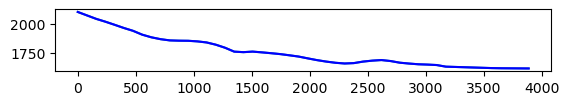

In [154]:
class glacierSim(glacierSim):
    def haversine(self, lat1, lon1, lat2, lon2):
        a = math.sin(math.radians(lat2 - lat1) / 2) ** 2 + math.cos(math.radians(lat1)) * math.cos( math.radians(lat2)) * math.sin(math.radians(lon2 - lon1) / 2) ** 2
        return 6371000*(2 * math.atan2(math.sqrt(a), math.sqrt(1 - a)))
        
    def calc_topo(self):
        #print("CALC TOPO")
        latitudes = []
        longitudes = []
        topo = []
        with open('centerlineBed.csv', 'r', newline='') as file:
            reader = csv.reader(file)
            next(reader)  # Skip the header line
            for row in reader:
                latitudes.append(float(row[2]))    # Latitude is the second column
                longitudes.append(float(row[1]))   # Longitude is the third column
                topo.append(float(row[0]))
        cumulative_distances=[0.0]
        for i in range(1, len(latitudes)): cumulative_distances.append(cumulative_distances[-1] + self.haversine(latitudes[i - 1], longitudes[i - 1], latitudes[i], longitudes[i]) )
        self.x=np.linspace(cumulative_distances[0], cumulative_distances[-1], self.num_cells)
        self.topo=np.interp(np.linspace(cumulative_distances[0], cumulative_distances[-1], self.num_cells), cumulative_distances, topo)
        self.valley_length=max(np.max(self.x),100)
        self.dx = self.valley_length/(self.num_cells-1)
        self.default_b = True
        self.ice_slope[:-1] = abs((np.diff(self.topo)/ self.dx))
        #self.ice=np.exp(-0.5 * ((self.x - 700) / 300) ** 2)
        #scale=300/np.max(self.ice)
        #self.ice*=scale
        self.ice_volume=np.sum(self.ice*self.widths*self.dx)
        self.initial_volume=self.ice_volume
        self.volume_change.append(self.initial_volume)
        
    def calc_widths(self):
        with open('Input_SouthCascade_Area_Altitude_Distribution.csv', 'r', newline='') as file:
            reader = csv.reader(file)
            for i,row in enumerate(reader):
                if i==0: self.bins = [float(item) for item in row[1:]]
                else:
                    self.years.append(float(row[0]))
                    self.areas.append([float(item) for item in row[1:]])
        self.bins=np.array(self.bins)
        self.areas=np.array(self.areas)
        self.widths=np.array([self.areas[0][np.array([np.argmin(np.abs(self.bins[:, None]-np.round(self.topo)), axis=0)])]][0][0])/0.05*1000
        
    def update_widths(self):
        prev_width=self.widths
        self.widths=np.array([self.areas[math.floor(self.run_time/365.25)-967][np.array([np.argmin(np.abs(self.bins[:, None]-np.round(self.topo)), axis=0)])]][0][0])/0.05*1000
        if np.abs(self.widths-prev_width).any()>0:
            self.widths_over_time.append(self.widths.copy())
            self.ice_thickness_over_time.append(self.ice.copy())
        
glac=glacierSim()
glac.calc_topo()
glac.calc_widths()
print(glac.topo)
plt.plot(glac.x, glac.topo)
plt.plot(glac.x,glac.ice+glac.topo, color='b')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [155]:
from math import floor


class glacierSim(glacierSim):
    def load_mb_data(self):
        with open('Input_SouthCascade_Daily_Weather.csv', 'r', newline='') as file:
            reader = csv.reader(file)
            next(reader)
            for row in reader:
                self.dates.append(datetime.strptime(row[0], "%Y/%m/%d"))
                self.temps.append(float(row[1]))
                self.precip.append(float(row[2]) if not np.isnan(float(row[2])) else 0)
        self.precip=np.array(self.precip)
    def load_verif_data(self):
        with open('Output_SouthCascade_Glacier_Wide_solutions_calibrated.csv', 'r', newline='') as file:
            reader = csv.reader(file)
            for _ in range(26): next(reader)
            for row in reader:
                if(float(row[0])>1983): 
                    self.annual_mb.append(float(row[3]))
                    self.summer_mb.append(float(row[2]))
                    self.winter_mb.append(float(row[1]))
        self.calculated_annual_mb=np.array([0] * len(self.annual_mb), dtype=np.float64)
        self.calculated_winter_mb=np.array([0] * len(self.winter_mb), dtype=np.float64)
        self.calculated_summer_mb=np.array([0] * len(self.summer_mb), dtype=np.float64)
    
    def snow_model(self, index, temps):
        x_temps=self.temps[index]+-0.004*(self.ice+self.topo-272)
        self.snow_depth[x_temps<0]+=(self.precip[index]*15)/1000
        self.snow_depth[x_temps>0]+=self.melt_factor*temps[x_temps>0]
        self.snow_depth[x_temps<0]-=self.snow_depth[x_temps<0]*self.accum_factor
    
    def update_b(self):
        if self.run_time>(1000*365.25):
            index=self.dates.index(datetime(1984, 1, 2) + timedelta(days=math.floor(self.run_time-(1000*365.25))))
            x_temps=self.temps[index]+-0.004*(self.ice+self.topo-272)
            mb=np.zeros_like(x_temps)
            mb[x_temps>0]=self.melt_factor*x_temps[x_temps>0]
            #mb[x_temps<0]=self.accum_factor*self.precip[index]/1000*self.dx
            self.snow_model(index,x_temps)
            mb[x_temps<0]=self.snow_depth[x_temps<0]*self.accum_factor
            # if np.any(mb[x_temps<0]<0): print("NEGATIVE MB", mb[x_temps<0])
            # if np.any(np.isnan(mb[x_temps < 0])): print("NAN MB", self.precip[index])
            # if np.any(mb[x_temps<0]>100): print("MB TOO BIG", mb[x_temps<0])
            #print(math.floor(self.run_time/365.25)-1000)
            date=math.floor((self.run_time-1000*365.25)/365.25)
            self.calculated_annual_mb[date]+=np.sum(np.array(mb))
            self.calculated_winter_mb[date]+=np.sum(np.array(mb[mb>0]))
            self.calculated_summer_mb[date]+=np.sum(np.array(mb[mb<0]))
            if np.any(self.calculated_winter_mb<0): print("ERROR IN WINTER MB")
            if np.any(self.calculated_summer_mb>0): print("ERROR IN WINTER MB")
            #print(self.calculated_annual_mb)
            return mb
        else: return ((self.topo+self.ice-self.curr_ela)*self.gamma)/365.25 #meters per day

In [156]:
class glacierSim(glacierSim):
    def calc_q(self):
        self.ice_slope[:-1] = -(np.diff(self.ice+self.topo) / self.dx) #calculate ice slope
        if np.any(np.isnan(self.ice_slope)): #and not self.quiet:
            print('NaN detected in ice_slope:', self.ice_slope)
            print("MASS BALANCE: ", self.b)
            print("TIME: ", self.run_time)
            #plt.plot(self.x, self.ice+self.topo)
            plt.plot(self.timestep_list)
            return
        if np.any(np.isnan(self.ice)): #and not self.quiet:
            print('NaN detected in ice:', self.ice)
            print("TIME: ", self.run_time)
            return
        if np.any(np.isinf(self.ice_slope)): # and not self.quiet:
            print('Infinity detected in ice_slope:', self.ice_slope)
            print('Ice: ',self.ice)
            print("Q: ",self.q)
            print("TIME: ", self.run_time)
            plt.plot(self.timestep_list)
            return
        #self.q[1:] = (0.2 *(2e-17*2) * (self.p * self.g)**2) * np.sin(np.arctan(self.ice_slope))**2 * (self.ice**5)/5
        #self.q[1:]=2e-17* ((self.p*self.g*np.sin(np.arctan(self.ice_slope)))**3)*((self.ice**5)/5) #YEARS
        self.q[1:]=5.87e-19* ((self.p*self.g*np.sin(np.arctan(self.ice_slope)))**3)*((self.ice**5)/5) #DAYS
        if np.any(np.isnan(self.q)): #and not self.quiet:
            print('NaN detected in q:', self.q)
            print(self.ice_slope)
            print(self.ice)
            print("TIME: ", self.run_time)
            #plt.plot(self.x, self.ice+self.topo)
            plt.plot(self.timestep_list)
            return
        if (self.prev_display==0.0 or ((self.run_time>=(self.prev_display+self.save)*365.25) and self.run_time<(self.time*365.25))) and not self.quiet:
            print("TIME: ", math.floor(self.run_time/365.25))
            print("ELA: ", self.curr_ela)
            print("ICE: ",self.ice)
            print("ICE VOLUME: ",self.ice_volume/1e9, " km^3")
            print("Difference from inital volume: ", self.ice_volume/1e9-self.initial_volume/1e9, " km^3")
            print("SLOPE: ",self.ice_slope)
            print("MASS BALANCE: ", self.b)
            print("Q: ",self.q)
            print("DQDX: ",np.diff(self.q)/self.dx)
            print("SUM Q: ", np.sum(self.q))
            print("SUM DQDX: ",np.sum(np.diff(self.q)/self.dx))
            print()
            self.prev_display=self.run_time/365.25

        return self.ice_slope,(self.b-(np.diff(self.q)/self.dx)) #calculate the change in ice thickness and return it

    def report_final_values(self,u):
        ice_extent = self.x[self.ice > 1]
        if ice_extent.size > 0:
            self.glacier_extent=np.max(ice_extent)
            print("Final glacier length: " + str(np.max(ice_extent)) + 'm')
        else: print("Final glacier length: 0m (no ice extent)")
        print("Final max ice thickness: " + str(np.max(self.ice)) + 'm')
        print('Final max velocity: ' +str(np.max(u)) + "m/yr")
        if(self.default_b):
            print('B min: ' + str(self.b_min))
            print('B max: ' + str(self.b_max))

    def run_model(self,i):
        if i==0 and not self.initial_run:
            self.initial_run=True
            try: curr_ela=self.topo[np.where((self.annual_mb_arr[:-1] >= 0) & (self.annual_mb_arr[1:] < 0))[0]][0]
            except: curr_ela=self.topo[-1]
            self.ela_list.append(curr_ela)
            ax.clear()
            ax.set_ylim(min(self.topo) - 100, max(self.topo) + 100)
            ax.set_xlim(0, float(self.valley_length))
            ax.set_ylabel("Height (m)")
            ax.set_xlabel("Distance (m)")
            ax.set_aspect('equal', adjustable='datalim')
            ax.plot(self.x, self.topo, color="b", label="Topography")
            ax.set_title('Time = ' + str(round((self.run_time/365.25),(str(self.save)[::-1].find('.')+1))) + ' years')
            self.ela_line = ax.axhline(y=curr_ela, color="r", linestyle="dashed", label="ELA")
            self.line = ax.plot(self.x, self.ice + self.topo, color="c", label="Ice")
            self.snow_line = ax.plot(self.x, self.snow_depth + self.topo+self.ice, color="g", label="Snow")
            ax.legend()
        elif i>0.0:
            iter_time=0.0 #years
            timestep=0.0 #days
            while(iter_time<self.save):
                if (self.save-iter_time)<(1/365.25): break
                ice_slope,dqdx=self.calc_q()
                u = (5.87e-19)*((self.p*self.g*np.sin(np.arctan(ice_slope)))**3)*(((self.ice)**4)/5)
                timestep = round(np.clip(((self.dx / np.max(u)) * 0.2), 0.0001, 1),5) if np.any(u > 0) else 1
                self.timestep_list.append(timestep)
                self.ice = np.maximum((self.ice + dqdx * timestep), 0.0)
                self.ice_volume=np.sum(self.ice*self.widths*self.dx)
                #self.volume_change.append(abs(self.ice_volume/1e9-self.initial_volume/1e9))
                iter_time+=timestep/365.25
                self.run_time+=timestep
                self.b=self.update_b()
                if math.floor(self.run_time%365.25)==0: self.annual_mb_arr=np.zeros(len(self.b))
                self.annual_mb_arr+=self.b
                self.b_max = max(np.max(self.b*365.25),self.b_max)
                self.b_min = min(np.min(self.b*365.25),self.b_min)
                if (self.run_time/365.24)>966: self.update_widths()
                #print(self.ice)
                
            if(iter_time>self.save):
                print("SHITS FUCKED ABORT ABORT")
                return
            ice_slope,dqdx=self.calc_q()
            timestep=(self.save-iter_time)*365.25
            self.timestep_list.append(timestep)
            self.ice = np.maximum((self.ice + dqdx * timestep), 0.0)
            self.ice_volume=np.sum(self.ice*self.dx*self.widths)
            #self.volume_change.append(abs(self.ice_volume/1e9-self.initial_volume/1e9))
            self.volume_change.append(self.ice_volume/1e9)
            self.run_time+=timestep
            self.b=self.update_b()
            if math.floor(self.run_time%365.25)==0: self.annual_mb_arr=np.zeros(len(self.b))
            self.annual_mb_arr+=self.b
            try: curr_ela=self.topo[np.where((self.annual_mb_arr[:-1] >= 0) & (self.annual_mb_arr[1:] < 0))][0]
            except: curr_ela=self.topo[-1]
            self.ela_list.append(curr_ela)
            ax.clear()
            ax.set_ylim(min(self.topo) - 100, max(self.topo) + 100)
            ax.set_xlim(0, float(self.valley_length))
            ax.set_ylabel("Height (m)")
            ax.set_xlabel("Distance (m)")
            ax.set_aspect('equal', adjustable='datalim')
            ax.plot(self.x, self.topo, color="b", label="Topography")
            ax.set_title('Time = ' + str(round((self.run_time/365.25),(str(self.save)[::-1].find('.')+1))) + ' years')
            self.ela_line = ax.axhline(y=curr_ela, color="r", linestyle="dashed", label="ELA")
            self.line = ax.plot(self.x, self.ice + self.topo, color="c", label="Ice")
            self.snow_line = ax.plot(self.x, self.snow_depth + self.topo+self.ice, color="g", label="Snow")
            ax.legend()
            if(round(self.run_time,2)==self.time*365.25): self.report_final_values(u)
        return self.line, self.ela_line, self.snow_line

#Initialize plotting stuff outside of class
fig, ax = plt.subplots() #initialize plotting variables
_ = plt.close(fig) #used to prevent an empty plot from displaying

Final glacier length: 3887.115317433839m
Final max ice thickness: 144.68294574907327m
Final max velocity: 0.06982539608139068m/yr
B min: -45.33455516118765
B max: 30.77254920967423
ICE:  [ 55.7026779   63.42309978  71.23485304  75.30744188  81.67733542
  90.32014276  98.32529456 116.66052509 127.98338097 134.0396237
 134.9533621  127.83343888 118.09994745 110.87899431 106.24169733
 110.48555616 122.68411704 144.68294575 140.37801734 126.3754326
 121.84883399 117.53645226 113.2629015  110.90002035 108.88326014
 111.68585552 114.74321689 116.37115044 116.50137996 113.22145462
 100.65444143  77.49513602  55.60191546  31.83864908  12.52810172
   2.06435626   1.96646205   1.90199012   1.79277139   1.77472005
   1.74445269   1.73797467   1.73061003   1.72348452   1.71751655
   1.71134346   1.70782097   1.7065233    1.70533577   1.70414825]
SLOPE:  [0.27744134 0.2762885  0.25676882 0.2556057  0.23598968 0.2085586
 0.18785507 0.14481205 0.12720602 0.12112394 0.120567   0.13393827
 0.15535529 0

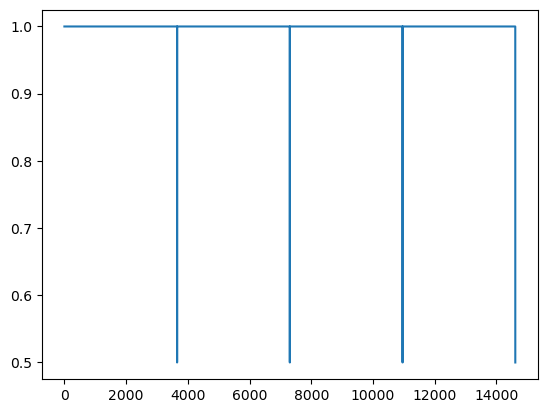

In [163]:
ela=1880
time=1040
save=10
gamma=0.011
quiet=True
#accumfactor=0.0005937275866062842
#meltfactor=-4.480001815757188e-05
meltfactor=-0.005
accumfactor=0.0008
start_time=1000
ice = [
    50.81674576, 58.0492316, 65.39974357, 69.26584673, 75.6541392, 84.5574082,
    93.16036408, 112.38704694, 124.70816911, 131.82922523, 133.94461492, 128.04731581,
    119.78368355, 114.48489418, 112.37514056, 119.75831875, 135.23782532, 160.12199208,
    157.96061715, 146.35333828, 145.00609809, 144.29791671, 144.11173286, 146.38344403,
    149.4198206, 157.63435841, 165.81155222, 172.08082136, 176.45849045, 177.06836948,
    168.17467552, 149.15732577, 133.66691108, 119.98983147, 118.42297763, 122.25852634,
    120.05965747, 116.45899098, 109.25399911, 102.33371904, 104.5723128, 96.17898237,
    86.71000822, 75.76864291, 62.64653003, 45.85246872, 20.18519449, 0.0, 0.0, 0.0
]
model = glacierSim(ela=ela, time=time, save=save,gamma=gamma,quiet=quiet, meltfactor=meltfactor, accumfactor=accumfactor, initial_ice=ice, start_time=start_time)
# plt.plot(glac.x, glac.topo)
# plt.plot(glac.x,glac.ice+glac.topo, color='b')
# plt.gca().set_aspect('equal', adjustable='box')
# plt.show()
#print(model.dx)
anim = FuncAnimation(fig, model.run_model, model.frames, init_func=model.init(ax,ela=ela, time=time, save=save,gamma=gamma,quiet=quiet, meltfactor=meltfactor, accumfactor=accumfactor, initial_ice=ice, start_time=start_time), blit=False, repeat=False)
vid = HTML(anim.to_jshtml())
print("ICE: ",model.ice)
print("SLOPE: ",model.ice_slope)
print("MASS BALANCE: ",model.b)
print("WINTER MB DIFF: ", model.winter_mb-model.calculated_winter_mb)
print("SUMMER MB DIFF: ", model.summer_mb-model.calculated_summer_mb)
#print('CALCULATED ANNUAL MB: ', model.calculated_annual_mb)
#print('MASS BALANCE DIFF: ',np.array(model.calculated_annual_mb)-np.array(model.annual_mb))
print("DONE")
#plt.plot(model.volume_change)
plt.plot(model.timestep_list)
#print(model.calculated_annual_mb, model.calculated_summer_mb, model.calculated_winter_mb)
#anim.save('animation.mp4', writer='ffmpeg', fps=15, dpi=100)
#print(model.calculated_summer_mb, model.calculated_winter_mb)
vid

[1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1616.145540047666, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0, 1613.0]


AttributeError: 'int' object has no attribute 'items'

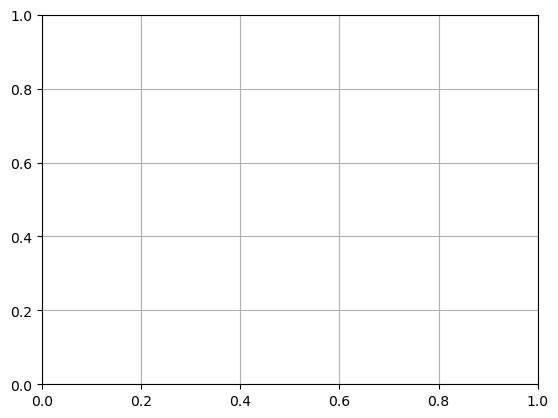

In [158]:
fig, ax = plt.subplots()
_ = plt.close(fig) #used to prevent an empty plot from displaying
# Initialize a line object
line, = ax.plot([], [], 'b-')

# Set the axis limits
ax.set_xlim(0, 4000)
ax.set_ylim(0, 12000)

# Define the update function
def update(frame):
    ax.clear()
    ax.set_xlim(0, 4000)
    ax.set_ylim(-6000, 6000)
    ax.set_ylabel("Width (m)")
    ax.set_xlabel("Distance (m)")
    ax.set_title("Time: ", frame+1000)
    half_widths = model.widths_over_time[frame] / 2
    ax.plot(model.x, half_widths, 'b-')  # Plot the positive half
    ax.plot(model.x, -half_widths, 'b-')  # Plot the negative half
    color = plt.cm.viridis(model.ice_thickness_over_time[frame] / np.max(model.ice_thickness_over_time))  # Normalize ice thickness for colormap
    for i in range(len(model.x) - 1):
        ax.fill_between(model.x[i:i+2], half_widths[i:i+2], -half_widths[i:i+2], color=color[i])
    return line,
print(model.ela_list)
#plt.plot((np.arange(0,model.time+model.save, model.save)), model.volume_change)
plt.grid()
# Create the animation
anim2 = FuncAnimation(fig, update, frames=len(model.widths_over_time), blit=False, repeat=False)
# Display the animation
vid2 = HTML(anim2.to_jshtml())

display(vid2)

In [22]:
from scipy.optimize import minimize
def objective(initial_guess):
    ela = 1880
    time = 1040
    save = 10
    meltfactor=initial_guess[0]
    gamma = 0.011
    accumfactor=initial_guess[1]
    quiet = True
    start_time = 1000
    ice = [
        50.81674576, 58.0492316, 65.39974357, 69.26584673, 75.6541392, 84.5574082,
        93.16036408, 112.38704694, 124.70816911, 131.82922523, 133.94461492, 128.04731581,
        119.78368355, 114.48489418, 112.37514056, 119.75831875, 135.23782532, 160.12199208,
        157.96061715, 146.35333828, 145.00609809, 144.29791671, 144.11173286, 146.38344403,
        149.4198206, 157.63435841, 165.81155222, 172.08082136, 176.45849045, 177.06836948,
        168.17467552, 149.15732577, 133.66691108, 119.98983147, 118.42297763, 122.25852634,
        120.05965747, 116.45899098, 109.25399911, 102.33371904, 104.5723128, 96.17898237,
        86.71000822, 75.76864291, 62.64653003, 45.85246872, 20.18519449, 0.0, 0.0, 0.0
    ]
    model = glacierSim(ela=ela, time=time, save=save, gamma=gamma, quiet=quiet, meltfactor=meltfactor, accumfactor=accumfactor,initial_ice=ice, start_time=start_time)
    
    anim = FuncAnimation(fig, model.run_model, model.frames, init_func=model.init(ax,ela=ela, time=time, save=save,gamma=gamma,quiet=quiet, meltfactor=meltfactor, accumfactor=accumfactor, initial_ice=ice, start_time=start_time), blit=False, repeat=False)
    vid = HTML(anim.to_jshtml()) 
    # Calculate the difference
    diff_annual = np.array(model.calculated_annual_mb) - np.array(model.annual_mb)
    diff_summer = np.array(model.calculated_summer_mb) - np.array(model.summer_mb)
    diff_winter = np.array(model.calculated_winter_mb) - np.array(model.winter_mb)
    print("MELTFACTOR: ", meltfactor)
    print("ACCUMFACTOR: ", accumfactor)
    # print("Diff Annual: ", diff_annual)
    # print("Diff Summer: ", diff_summer)
    print("Diff Winter: ", diff_winter)
    return np.sum(diff_winter ** 2)  # Sum of squared differences

# Initialize the model
meltfactor=-4.480001815757188e-05
accumfactor=0.0005940382930300982

# Optimize the meltfactor and accumfactor
initial_guess = [meltfactor, accumfactor]
result = minimize(objective, initial_guess, method='BFGS', options={'disp': True})
# Update the model with the optimized parameters
model.melt_factor, model.accum_factor = result.x

# Print the optimized parameters
print("Optimized melt factor:", model.melt_factor)
print("Optimized accumulation factor:", model.accum_factor)


Final glacier length: 3887.115317433839m
Final max ice thickness: 173.52301019851262m
Final max velocity: 0.01773990095375693m/yr
B min: -0.40269339149845484
B max: 2.753949635427035
MELTFACTOR:  -4.480001815757188e-05
ACCUMFACTOR:  0.0005940382930300982
Diff Winter:  [ 0.26392523 -0.20224878  0.67475245  0.03642397  0.70575535 -0.29392719
  1.63153236 -0.47911809  0.15841425 -0.02950123  1.19537086 -0.17448726
  0.59907216 -0.9227939   0.21237514 -0.3037313  -1.21980262  0.73279465
 -0.85130101  1.1260724   0.3089712   0.23899188  0.97413949 -0.73616838
 -0.99089092  0.22700374 -0.37596602  0.35919434 -0.28664406 -0.92620082
 -0.19187196 -0.05173052 -0.94725885 -0.61567042 -0.70990795 -0.45224098
  0.02420234 -0.041797   -0.78961626 -0.82536635 -2.47      ]
Final glacier length: 3887.115317433839m
Final max ice thickness: 173.52391497824473m
Final max velocity: 0.01774023630228499m/yr
B min: -0.40255923612765043
B max: 2.753949635427035
MELTFACTOR:  -4.478511699637803e-05
ACCUMFACTOR:

KeyboardInterrupt: 

In [155]:
# ela = 1880
# time = 1000
# save = 1000
# gamma =0.00395
# precision = 0.000001
# upper_bound=0.00396

# while precision >= 1e-7:
#     gamma_list = np.arange(gamma, upper_bound+precision, precision)
#     for i in gamma_list:
#         print(i)
#         model = glacierSim(ela=ela, time=time, save=save, gamma=i)
#         anim = FuncAnimation(fig, model.run_model, model.frames, init_func=model.init(ax, ela=ela, time=time, save=save, gamma=i), blit=False, repeat=False)
#         vid = HTML(anim.to_jshtml())
#         # display(vid)
#         if 3626 <= model.glacier_extent <= 3646:
#             print("Final gamma: ", i)
#             precision /= 10
#             gamma = i - precision
#             break
#         if model.glacier_extent > 3656:
#             print('Extent overreached, ending')
#             precision /= 10
#             gamma = i - precision
#             upper_bound=gamma
#             break

In [156]:
# import numpy as np
# from scipy.optimize import differential_evolution

# # Define the objective function to minimize
# def objective(meltfactor):
#     ela = 1880
#     time = 40
#     save = 10
#     gamma = 0.011
#     quiet = True
#     start_time = 1000
#     ice = [
#         50.81674576, 58.0492316, 65.39974357, 69.26584673, 75.6541392, 84.5574082,
#         93.16036408, 112.38704694, 124.70816911, 131.82922523, 133.94461492, 128.04731581,
#         119.78368355, 114.48489418, 112.37514056, 119.75831875, 135.23782532, 160.12199208,
#         157.96061715, 146.35333828, 145.00609809, 144.29791671, 144.11173286, 146.38344403,
#         149.4198206, 157.63435841, 165.81155222, 172.08082136, 176.45849045, 177.06836948,
#         168.17467552, 149.15732577, 133.66691108, 119.98983147, 118.42297763, 122.25852634,
#         120.05965747, 116.45899098, 109.25399911, 102.33371904, 104.5723128, 96.17898237,
#         86.71000822, 75.76864291, 62.64653003, 45.85246872, 20.18519449, 0.0, 0.0, 0.0
#     ]
#     model = glacierSim(ela=ela, time=time, save=save, gamma=gamma, quiet=quiet, meltfactor=meltfactor, initial_ice=ice, start_time=start_time)
    
#     anim = FuncAnimation(fig, model.run_model, model.frames, init_func=model.init(ax,ela=ela, time=time, save=save,gamma=gamma,quiet=quiet, meltfactor=meltfactor, initial_ice=ice, start_time=start_time), blit=False, repeat=False)
#     vid = HTML(anim.to_jshtml()) 
#     # Calculate the difference
#     diff = np.array(model.calculated_annual_mb) - np.array(model.annual_mb)
#     return np.sum(diff ** 2)  # Sum of squared differences

# # Initial guess for meltfactor
# initial_meltfactor = 0.0000018

# # Perform the optimization
# result = differential_evolution(objective, bounds=[(0, 1e-5)], strategy='best1bin', maxiter=1000, tol=1e-7)

# # Update the model with the optimized meltfactor
# optimized_meltfactor = result.x[0]

# # Print the optimized meltfactor
# print("Optimized meltfactor:", optimized_meltfactor)

# # Run the model with the optimized meltfactor and print the results
# # model = glacierSim(ela=1880, time=40, save=10, gamma=0.011, quiet=True, meltfactor=optimized_meltfactor, initial_ice=ice, start_time=1000)
# # model.run_model(0)
# # print('CALCULATED ANNUAL MB: ', model.calculated_annual_mb)
# # print('MASS BALANCE DIFF: ', np.array(model.calculated_annual_mb) - np.array(model.annual_mb))